# SETUP

# ***Warning!!!!***

В предоставленой нотбуком версии была ошибка во время обучения:

TypeError: Accelerator.__init__() got an unexpected keyword argument 'logging_dir';

---------------


**Для того, чтобы исправить эту ошибку достаточно поменять** в `lora/training_scripts/train_lora_dreambooth.py`

строку 493:`logging_dir=logging_dir -> project_dir=logging_dir;`


Подробней можно посмотреть в моём pull-request: https://github.com/cloneofsimo/lora/pull/256/commits/af34fa60528be6f4f60b59e92d1eed267ff47493


ЕСЛИ НЕ ИСПРАВИТЬ ОШИБКУ, ТО ПРИ ОБУЧЕНИИ БУДЕТ КИДАТЬ `TypeError: Accelerator.__init__() got an unexpected keyword argument 'logging_dir'; `


In [ ]:
!git clone https://github.com/cloneofsimo/lora.git && sed -i 's/functools.cache/functools.lru_cache(maxsize=None)/g' /content/lora/lora_diffusion/xformers_utils.py && pip install /content/lora
!pip install accelerate bitsandbytes
!pip install transformers -U

fatal: destination path 'lora' already exists and is not an empty directory.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# TRAINING


1. Укажите RARE_TOKEN-(sks, http, oue), CLASS-(dog, cat, car). Promt формируется так: "A {RARE_TOKEN} {CLASS}"
2. OUTPUT_DIR - директория куда загрузятся веса или откуда выгрузятся веса при inference.
3. IMAGES_FOLDER_OPTIONAL - путь к вашему датасету.

## Если хотите обучить модель
Запускаем последовательно ячейки, читаем комментарии, заполняем поля входных данных и смотрим на результаты!

## Если хотите протестировать модель
Заполняем следующую ячейку и переходим к разделу INFERENCE. Если вы тестируете веса, которые обучались в режиме TRAIN_TEXT_ENCODER, то ставим галочку для TRAIN_TEXT_ENCODER

In [ ]:
import os
import shutil
from google.colab import files
from tqdm import tqdm

PRETRAINED_MODEL="runwayml/stable-diffusion-v1-5" #@param{type: 'string'}
CLASS="dog" #@param{type: 'string'}
RARE_TOKEN="hta" #@param{type: 'string'}
PROMPT = f"A {RARE_TOKEN} {CLASS}"
SEED=42 #@param {type:"number"}


OUTPUT_DIR="/content/drive/MyDrive/exp_inf/" #@param{type: 'string'}
IMAGES_FOLDER_OPTIONAL="/content/drive/MyDrive/small_dog/" #@param{type: 'string'}

RESOLUTION="512" #@param ["512", "576", "640", "704", "768", "832", "896", "960", "1024"]
RESOLUTION=int(RESOLUTION)


#@markdown ----
#@markdown Если вы тестируете веса, которые обучались в режиме TRAIN_TEXT_ENCODER( или хотите обучить в этом режиме), то ставим галочку:
TRAIN_TEXT_ENCODER = False #@param {type:"boolean"}

if PRETRAINED_MODEL == "":
  print('[1;31mYou should define the pretrained model.')

else:
  if IMAGES_FOLDER_OPTIONAL=="":
    INSTANCE_DIR = "/content/data_example"
    if not os.path.exists(str(INSTANCE_DIR)):
      %mkdir -p "$INSTANCE_DIR"
    uploaded = files.upload()
    for filename in tqdm(uploaded.keys(), bar_format='  |{bar:15}| {n_fmt}/{total_fmt} Uploaded'):
        shutil.move(filename, INSTANCE_DIR)
  else:
    INSTANCE_DIR = IMAGES_FOLDER_OPTIONAL

  if OUTPUT_DIR == "":
    OUTPUT_DIR = "/content/output"
  if not os.path.exists(str(OUTPUT_DIR)):
    %mkdir -p "$OUTPUT_DIR"

In [ ]:
STEPS = 450 #@param {type:"slider", min:0, max:10000, step:10}
BATCH_SIZE = 1 #@param {type:"slider", min:0, max:128, step:1}
FP_16 = True #@param {type:"boolean"}

#@markdown ----
#@markdown UNET PARAMS
LEARNING_RATE = 3e-4 #@param {type:"number"}

#@markdown ----
#@markdown TEXT ENCODER PARAMS
LEARNING_RATE_TEXT_ENCODER = 1e-4 #@param {type:"number"}

NEW_LEARNING_RATE = LEARNING_RATE / BATCH_SIZE
NEW_LEARNING_RATE_TEXT_ENCODER = LEARNING_RATE_TEXT_ENCODER / BATCH_SIZE

if FP_16:
  fp_16_arg = "fp16"
else:
  fp_16_arg = "no"

if TRAIN_TEXT_ENCODER:
  command = (f'accelerate launch lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--instance_prompt="{PROMPT}" '
             f'--resolution=512 '
             f'--use_8bit_adam '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size=1 '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={NEW_LEARNING_RATE} '
             f'--lr_scheduler="constant" '
             f'--lr_warmup_steps=0 '
             f'--max_train_steps={STEPS} '
             f'--train_text_encoder '
             f'--lora_rank=16 '
             f'--learning_rate_text={NEW_LEARNING_RATE_TEXT_ENCODER} '
             f'--seed=42 ')
else:
  command = (f'accelerate launch lora/training_scripts/train_lora_dreambooth.py '
             f'--pretrained_model_name_or_path="{PRETRAINED_MODEL}" '
             f'--instance_data_dir="{INSTANCE_DIR}" '
             f'--output_dir="{OUTPUT_DIR}" '
             f'--instance_prompt="{PROMPT}" '
             f'--resolution=512 '
             f'--use_8bit_adam '
             f'--mixed_precision="{fp_16_arg}" '
             f'--train_batch_size=1 '
             f'--gradient_accumulation_steps=1 '
             f'--learning_rate={NEW_LEARNING_RATE} '
             f'--lr_scheduler="constant" '
             f'--lr_warmup_steps=0 '
             f'--lora_rank=16 '
             f'--max_train_steps={STEPS} '
             f'--seed=42 '
             f'--learning_rate_text={NEW_LEARNING_RATE_TEXT_ENCODER} ')
!rm -rf $INSTANCE_DIR/.ipynb_checkpoints
!{command}

2023-08-29 19:25:57.562098: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2023-08-29 19:26:02.632442: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Before training: Unet First Layer lora up tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Before training: Unet First Layer lora down tensor([[ 0.0198,  0.0439, -0

# INFERENCE

In [ ]:
#@title LOADING MODEL AND MONKEY PATCHING IT
import torch
from lora_diffusion import monkeypatch_or_replace_lora, tune_lora_scale
from diffusers import StableDiffusionPipeline


pipe = StableDiffusionPipeline.from_pretrained(PRETRAINED_MODEL, torch_dtype=torch.float16, use_safetensors=True).to("cuda")
monkeypatch_or_replace_lora(pipe.unet, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.pt")))
if TRAIN_TEXT_ENCODER:
  monkeypatch_or_replace_lora(pipe.text_encoder, torch.load(os.path.join(OUTPUT_DIR, "lora_weight.text_encoder.pt")), target_replace_module=["CLIPAttention"])

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
pipe.safety_checker = None


# Validation random seed

В этом разделе мы рандомно генерируем 4 random seed для генерации картинки и смотрим на результаты

In [ ]:
from PIL import Image
# функция для рисования нескольких картинок
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
# генерируем нескольео random-seed для латентного пространства для тестирование
num_images = 4
width = 512
height = 512
device = "cuda"
generator = torch.Generator(device=device)
latents = None
seeds = []
for _ in range(num_images):
    # Get a new random seed, store it and use it as the generator state
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)

    image_latents = torch.randn(
        (1, pipe.unet.in_channels, height // 8, width // 8),
        generator = generator,
        device = device
    )
    latents = image_latents if latents is None else torch.cat((latents, image_latents))

# latents should have shape (4, 4, 64, 64) in this case
latents.shape

<ipython-input-117-e2a63274a4a3>:16: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, pipe.unet.in_channels, height // 8, width // 8),


torch.Size([4, 4, 64, 64])

In [ ]:
INFERENCE_PROMPT = f'A {RARE_TOKEN} {CLASS} '
LORA_SCALE_UNET = 0.6 #@param {type:"number"}
LORA_SCALE_TEXT_ENCODER = 0.6 #@param {type:"number"}
GUIDANCE = 6.4 #@param {type:"slider", min:0, max:15, step:0.2}
tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
#if TRAIN_TEXT_ENCODER:
#  tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)

with torch.autocast("cuda"):
  images = pipe([INFERENCE_PROMPT]*num_images, num_inference_steps=160, guidance_scale=GUIDANCE, latents = latents).images

  0%|          | 0/160 [00:00<?, ?it/s]

## Смотрим на картинки с разным random seed

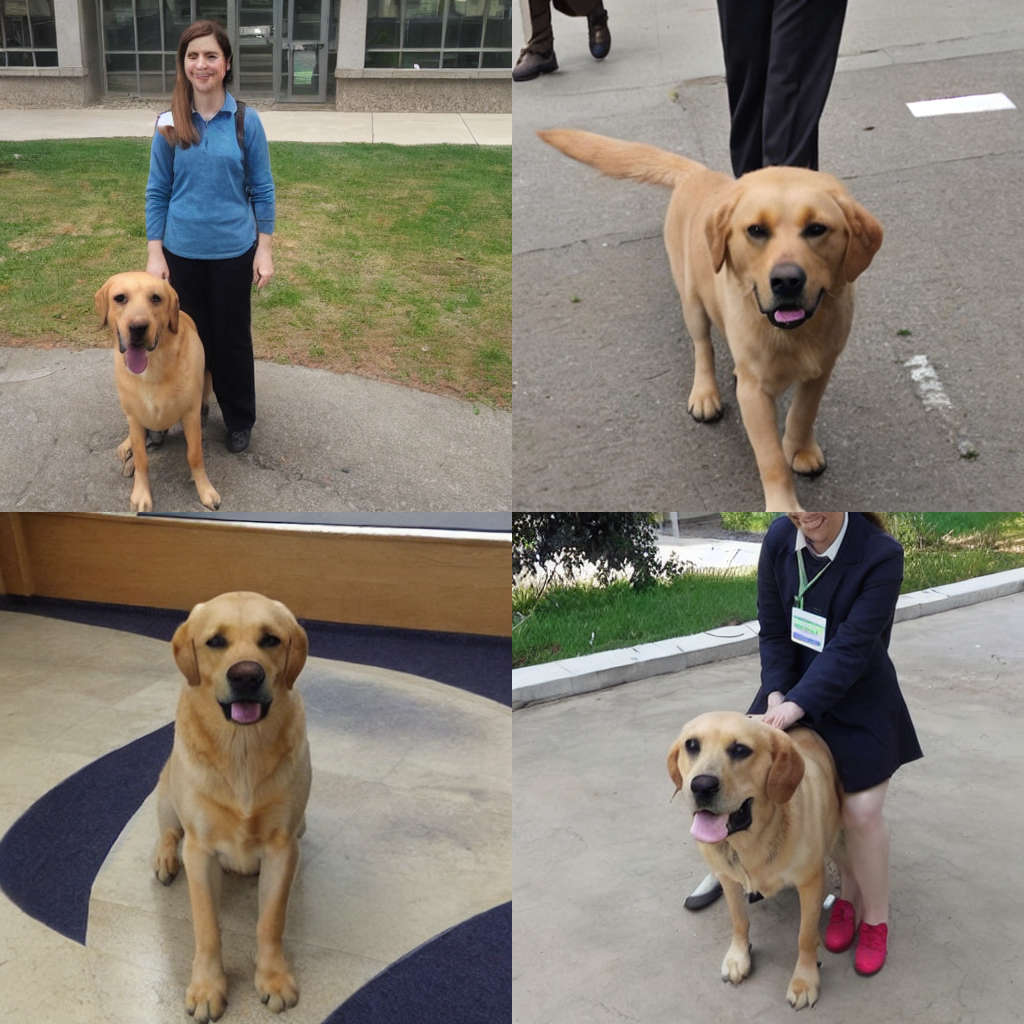

In [ ]:
image_grid(images, 2, 2)

In [ ]:
seeds  # смотрим значения seeds и выбираем то, которое соответствует самой хорошкй картинке

[2755452453625358, 5214883712862421, 2909881346002080, 8077461472812382]

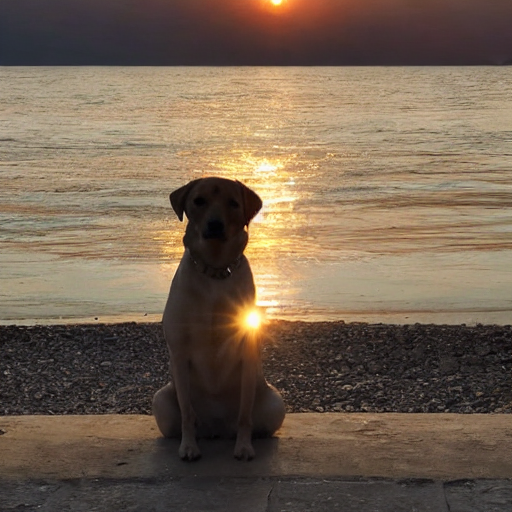

In [ ]:
images[0]

# Test

## Здесь вы можете задать свои тестовые промты! (ровно 4шт)

In [ ]:
promts = [f'A {RARE_TOKEN} {CLASS} in red t-shorts',
          f'A {RARE_TOKEN} {CLASS} in the style of van gogh',
          f'A {RARE_TOKEN} {CLASS} in the forest',
          f'A {RARE_TOKEN} {CLASS}  driving car']

In [ ]:
# Создаём несколько тестовых картинок с тестовыми промтамии

seed =14    # вписываем лучший random seed # ВНИМАНИЕ для повторения впишите сюда seed
latents = None
for _ in range(4):
    generator = generator.manual_seed(seed)

    image_latents = torch.randn(
        (1, pipe.unet.in_channels, height // 8, width // 8),
        generator = generator,
        device = device
    )
    latents = image_latents if latents is None else torch.cat((latents, image_latents))


<ipython-input-42-903ed474ab98>:9: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, pipe.unet.in_channels, height // 8, width // 8),


In [ ]:
LORA_SCALE_UNET = 0.4 #@param {type:"number"}
LORA_SCALE_TEXT_ENCODER = 0.4 #@param {type:"number"}
GUIDANCE = 6.4 #@param {type:"slider", min:0, max:15, step:0.2}
tune_lora_scale(pipe.unet, LORA_SCALE_UNET)
#if TRAIN_TEXT_ENCODER:
#  tune_lora_scale(pipe.text_encoder, LORA_SCALE_TEXT_ENCODER)

with torch.autocast("cuda"):
  images = pipe(promts, num_inference_steps=150, guidance_scale=GUIDANCE, latents = latents).images

  0%|          | 0/150 [00:00<?, ?it/s]

## Смотрим на резултат!

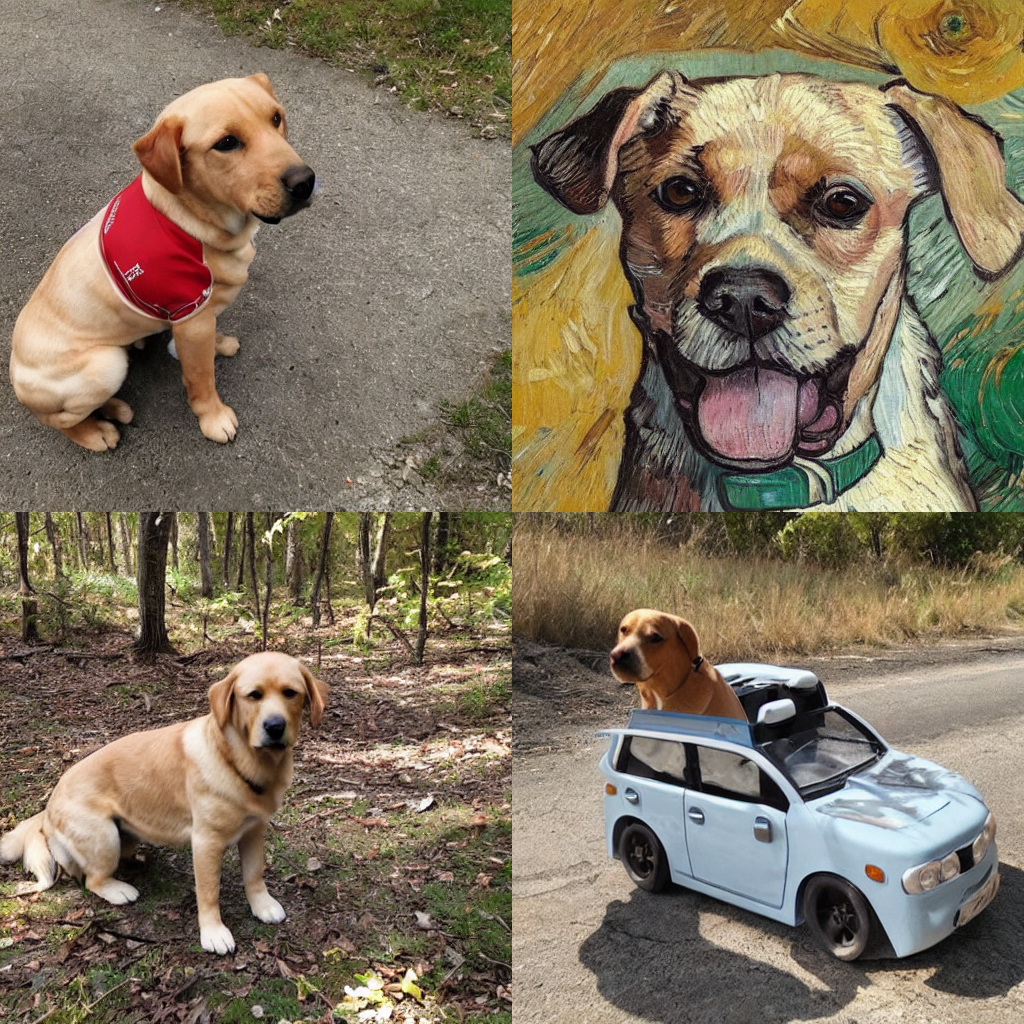

In [ ]:
image_grid(images, 2, 2)

In [ ]:
promts

['A oue dog in red t-shorts',
 'A oue dog in the style of van gogh',
 'A oue dog in the forest',
 'A oue dog  driving car']

  0%|          | 0/150 [00:00<?, ?it/s]

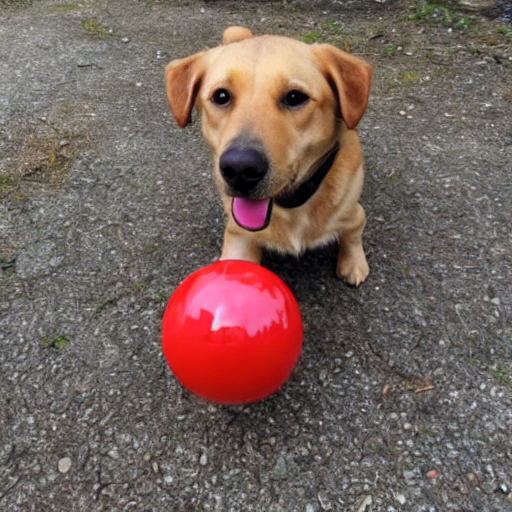

In [ ]:
pipe('A http dog with red ball', num_inference_steps=150, guidance_scale=GUIDANCE).images[0]